Considerando o conjunto de dados utilizado em 2-sentiment.ipynb,
* Fazer uma cópia do notebook para o seu drive.
* Aproveitar o código de 2-word-embeddings.ipynb que for necessário.
* Plotar as palavras após tokenização usando o modelo pre-treinado utilizado no notebook 2-word-embeddings.ipynb, ao invés do modelo que treinamos,  e usando o modelo que treinamento em 2-sentiment. Enviar o plot de ambos como imagem na tarefa.

# Modelo de embeddings pré-treinado

 Vamos usar o gensim para carregar o modelo, que é baseado no word2vec, treinado na Wikipedia em vetores de 100 dimensões.


In [30]:
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
model_w2v = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/wikipedia2vec_ptwiki_20180420_100d", filename="ptwiki_20180420_100d.txt"))

# Carregando e tratando os dados

In [31]:
import re    # expressao regular
import nltk  # processamento de textos
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns  # gráficos
import matplotlib.pyplot as plt
import gensim

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [32]:
nfile = 'tweetsentbr.csv'
df  = pd.read_csv(nfile)

Inspecionando o csv

In [33]:
df.shape

(7769, 2)

In [34]:
df.head()

,tweet,class
0,Que coisa linda! O Programa #encontro estava mostrando uma familia que adotou um adolescente de 18 anos. Que amor!!!,1
1,"Por mais #Encontro com as Irmãs Galvão, adorei elas.",1
2,Mr. CATRA @OficialMrCatra lançando sua nova música PPK CHORA no @SBTTheNoite k k k��\r\n#TheNoite #MrCatra #PpkChora,1
3,"Cibele arrasou, humilhou!! #VideoShowAoVivo",1
4,A Cearamirinense mais famosa do Brasil no #Edecasa @_robertasa ♥ Linda,1


In [35]:
df['class'].value_counts()

class
1    4773
0    2996
Name: count, dtype: int64

In [36]:
df[df['class'] == 1].head(10)

,tweet,class
0,Que coisa linda! O Programa #encontro estava mostrando uma familia que adotou um adolescente de 18 anos. Que amor!!!,1
1,"Por mais #Encontro com as Irmãs Galvão, adorei elas.",1
2,Mr. CATRA @OficialMrCatra lançando sua nova música PPK CHORA no @SBTTheNoite k k k��\r\n#TheNoite #MrCatra #PpkChora,1
3,"Cibele arrasou, humilhou!! #VideoShowAoVivo",1
4,A Cearamirinense mais famosa do Brasil no #Edecasa @_robertasa ♥ Linda,1
5,"nào sei vocês, mas quero @marcos_harter no #powercoupleBrasil com a @emillyaraujoof e num reality tipo Dr Rey. Até no #MasterChefBR tá bom",1
6,Tem q passar essa entrevista em telões nas praças\r\n#TheNoite,1
7,Estou todo derretido com o amor do Serginho e Thomas no #AltasHoras,1
8,Augusto Cury no #ConversaComBial IMPERDÍVEL!!!,1
9,#VideoShowAoVivo Sophia super sensual com essa roupa!!!!!!!!,1


In [37]:
df_new = df[['tweet', 'class']]
df_new.head()

,tweet,class
0,Que coisa linda! O Programa #encontro estava mostrando uma familia que adotou um adolescente de 18 anos. Que amor!!!,1
1,"Por mais #Encontro com as Irmãs Galvão, adorei elas.",1
2,Mr. CATRA @OficialMrCatra lançando sua nova música PPK CHORA no @SBTTheNoite k k k��\r\n#TheNoite #MrCatra #PpkChora,1
3,"Cibele arrasou, humilhou!! #VideoShowAoVivo",1
4,A Cearamirinense mais famosa do Brasil no #Edecasa @_robertasa ♥ Linda,1


limpando os dados

In [38]:
# limpeza do word2vec do tweetsentbr original: https://bitbucket.org/HBrum/tweetsentbr/src/master/

# Punctuation list
punctuations = re.escape('!"#%\'()*+,./:;<=>?@[\\]^_`{|}~')

# ##### #
# Regex #
# ##### #
re_remove_brackets = re.compile(r'\{.*\}')
re_remove_html = re.compile(r'<(\/|\\)?.+?>', re.UNICODE)
re_transform_numbers = re.compile(r'\d', re.UNICODE)
re_transform_emails = re.compile(r'[^\s]+@[^\s]+', re.UNICODE)
re_transform_url = re.compile(r'(http|https)://[^\s]+', re.UNICODE)
re_transform_username = re.compile(r'@[^\s]+', re.UNICODE)
# Different quotes are used.
re_quotes_1 = re.compile(r"(?u)(^|\W)[‘’′`']", re.UNICODE)
re_quotes_2 = re.compile(r"(?u)[‘’`′'](\W|$)", re.UNICODE)
re_quotes_3 = re.compile(r'(?u)[‘’`′“”]', re.UNICODE)
re_dots = re.compile(r'(?<!\.)\.\.(?!\.)', re.UNICODE)
re_punctuation = re.compile(r'([,";:]){2},', re.UNICODE)
re_hiphen = re.compile(r' -(?=[^\W\d_])', re.UNICODE)
re_tree_dots = re.compile(u'…', re.UNICODE)
# Differents punctuation patterns are used.
re_punkts = re.compile(r'(\w+)([%s])([ %s])' %
                       (punctuations, punctuations), re.UNICODE)
re_punkts_b = re.compile(r'([ %s])([%s])(\w+)' %
                         (punctuations, punctuations), re.UNICODE)
re_punkts_c = re.compile(r'(\w+)([%s])$' % (punctuations), re.UNICODE)
re_changehyphen = re.compile(u'–')
re_doublequotes_1 = re.compile(r'(\"\")')
re_doublequotes_2 = re.compile(r'(\'\')')
re_trim = re.compile(r' +', re.UNICODE)


def clean_text(text):
    """Apply all regex above to a given string."""
    text = text.lower()
    text = text.replace('\xa0', ' ')
    text = text.replace('#', ' ')
    text = re_tree_dots.sub('...', text)
    text = re.sub('\.\.\.', '', text)
    text = re_remove_brackets.sub('', text)
    text = re_changehyphen.sub('-', text)
    text = re_remove_html.sub(' ', text)
    text = re_transform_numbers.sub('0', text)
    text = re_transform_url.sub('URL', text)
    text = re_transform_username.sub('USERNAME', text)
    text = re_transform_emails.sub('EMAIL', text)
    text = re_quotes_1.sub(r'\1"', text)
    text = re_quotes_2.sub(r'"\1', text)
    text = re_quotes_3.sub('"', text)
    text = re.sub('"', '', text)
    text = re_dots.sub('.', text)
    text = re_punctuation.sub(r'\1', text)
    text = re_hiphen.sub(' - ', text)
    text = re_punkts.sub(r'\1 \2 \3', text)
    text = re_punkts_b.sub(r'\1 \2 \3', text)
    text = re_punkts_c.sub(r'\1 \2', text)
    text = re_doublequotes_1.sub('\"', text)
    text = re_doublequotes_2.sub('\'', text)
    text = re_trim.sub(' ', text)
    return text.strip()

In [39]:
#df_new['clean_tweet'] = df_new['tweet'].apply(lambda x: clean_text(x))

df_new['clean_tweet'] = np.vectorize(clean_text)(df['tweet'])
df_new.head(10)

,tweet,class,clean_tweet
0,Que coisa linda! O Programa #encontro estava mostrando uma familia que adotou um adolescente de 18 anos. Que amor!!!,1,que coisa linda ! o programa encontro estava mostrando uma familia que adotou um adolescente de 00 anos . que amor ! !!
1,"Por mais #Encontro com as Irmãs Galvão, adorei elas.",1,"por mais encontro com as irmãs galvão , adorei elas ."
2,Mr. CATRA @OficialMrCatra lançando sua nova música PPK CHORA no @SBTTheNoite k k k��\r\n#TheNoite #MrCatra #PpkChora,1,mr . catra USERNAME lançando sua nova música ppk chora no USERNAME k k k��\r\n thenoite mrcatra ppkchora
3,"Cibele arrasou, humilhou!! #VideoShowAoVivo",1,"cibele arrasou , humilhou ! ! videoshowaovivo"
4,A Cearamirinense mais famosa do Brasil no #Edecasa @_robertasa ♥ Linda,1,a cearamirinense mais famosa do brasil no edecasa USERNAME ♥ linda
5,"nào sei vocês, mas quero @marcos_harter no #powercoupleBrasil com a @emillyaraujoof e num reality tipo Dr Rey. Até no #MasterChefBR tá bom",1,"nào sei vocês , mas quero USERNAME no powercouplebrasil com a USERNAME e num reality tipo dr rey . até no masterchefbr tá bom"
6,Tem q passar essa entrevista em telões nas praças\r\n#TheNoite,1,tem q passar essa entrevista em telões nas praças\r\n thenoite
7,Estou todo derretido com o amor do Serginho e Thomas no #AltasHoras,1,estou todo derretido com o amor do serginho e thomas no altashoras
8,Augusto Cury no #ConversaComBial IMPERDÍVEL!!!,1,augusto cury no conversacombial imperdível ! !!
9,#VideoShowAoVivo Sophia super sensual com essa roupa!!!!!!!!,1,videoshowaovivo sophia super sensual com essa roupa ! !!!!!!!


In [40]:
# remover palavras com menos que 3 letras
df_new.clean_tweet = df_new.clean_tweet.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
df_new.head(10)

,tweet,class,clean_tweet
0,Que coisa linda! O Programa #encontro estava mostrando uma familia que adotou um adolescente de 18 anos. Que amor!!!,1,coisa linda programa encontro estava mostrando familia adotou adolescente anos amor
1,"Por mais #Encontro com as Irmãs Galvão, adorei elas.",1,mais encontro irmãs galvão adorei elas
2,Mr. CATRA @OficialMrCatra lançando sua nova música PPK CHORA no @SBTTheNoite k k k��\r\n#TheNoite #MrCatra #PpkChora,1,catra USERNAME lançando nova música chora USERNAME thenoite mrcatra ppkchora
3,"Cibele arrasou, humilhou!! #VideoShowAoVivo",1,cibele arrasou humilhou videoshowaovivo
4,A Cearamirinense mais famosa do Brasil no #Edecasa @_robertasa ♥ Linda,1,cearamirinense mais famosa brasil edecasa USERNAME linda
5,"nào sei vocês, mas quero @marcos_harter no #powercoupleBrasil com a @emillyaraujoof e num reality tipo Dr Rey. Até no #MasterChefBR tá bom",1,vocês quero USERNAME powercouplebrasil USERNAME reality tipo masterchefbr
6,Tem q passar essa entrevista em telões nas praças\r\n#TheNoite,1,passar essa entrevista telões praças thenoite
7,Estou todo derretido com o amor do Serginho e Thomas no #AltasHoras,1,estou todo derretido amor serginho thomas altashoras
8,Augusto Cury no #ConversaComBial IMPERDÍVEL!!!,1,augusto cury conversacombial imperdível
9,#VideoShowAoVivo Sophia super sensual com essa roupa!!!!!!!!,1,videoshowaovivo sophia super sensual essa roupa !!!!!!!


tokenizando os dados

In [41]:
def tokenize(text):
  final = ""
  for sent in sent_tokenizer.tokenize(text):

    if sent.count(' ') >= 3 and sent[-1] in ['.', '!', '?', ';']:

      if sent[0:2] == '- ':
        sent = sent[2:]

      elif sent[0] == ' ' or sent[0] == '-':
        sent = sent[1:]

    final += sent
  return final

In [42]:
import nltk
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer
nltk.download('punkt')

sent_tokenizer = PunktSentenceTokenizer('portuguese')

df_new['tokenized_tweet'] = df_new.clean_tweet.apply(lambda x: tokenize(x))
df_new.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oknotok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,tweet,class,clean_tweet,tokenized_tweet
0,Que coisa linda! O Programa #encontro estava mostrando uma familia que adotou um adolescente de 18 anos. Que amor!!!,1,coisa linda programa encontro estava mostrando familia adotou adolescente anos amor,coisa linda programa encontro estava mostrando familia adotou adolescente anos amor
1,"Por mais #Encontro com as Irmãs Galvão, adorei elas.",1,mais encontro irmãs galvão adorei elas,mais encontro irmãs galvão adorei elas
2,Mr. CATRA @OficialMrCatra lançando sua nova música PPK CHORA no @SBTTheNoite k k k��\r\n#TheNoite #MrCatra #PpkChora,1,catra USERNAME lançando nova música chora USERNAME thenoite mrcatra ppkchora,catra USERNAME lançando nova música chora USERNAME thenoite mrcatra ppkchora
3,"Cibele arrasou, humilhou!! #VideoShowAoVivo",1,cibele arrasou humilhou videoshowaovivo,cibele arrasou humilhou videoshowaovivo
4,A Cearamirinense mais famosa do Brasil no #Edecasa @_robertasa ♥ Linda,1,cearamirinense mais famosa brasil edecasa USERNAME linda,cearamirinense mais famosa brasil edecasa USERNAME linda


In [43]:
tokenized_tweet = df_new['tokenized_tweet'].apply(lambda x: x.split()) # tokenizing
tokenized_tweet.head()

0    [coisa, linda, programa, encontro, estava, mostrando, familia, adotou, adolescente, anos, amor]
1                                                      [mais, encontro, irmãs, galvão, adorei, elas]
2            [catra, USERNAME, lançando, nova, música, chora, USERNAME, thenoite, mrcatra, ppkchora]
3                                                       [cibele, arrasou, humilhou, videoshowaovivo]
4                                   [cearamirinense, mais, famosa, brasil, edecasa, USERNAME, linda]
Name: tokenized_tweet, dtype: object

In [44]:
palavras = []

for i in tokenized_tweet:
    for j in i:
        if j not in palavras:
            palavras.append(j)

palavras = sorted(palavras,
               key=lambda palavra: len(palavras),
               reverse=True)

Vetor de palavras com o modelo pré-treinado

In [45]:
# def word_vector(tokens, size):
#     vec = np.zeros(size).reshape((1, size))
#     count = 0
#     for word in tokens:
#         try:
#             vec += model_w2v.get_vector(word).reshape((1, size))
#             count += 1.
#         except KeyError:  # handling the case where the token is not in vocabulary
#             continue
#     if count != 0:
#         vec /= count
#     return vec

def word_vector(token, size):
    vec = np.zeros(size).reshape((1, size))
    try:
        vec += model_w2v.get_vector(token).reshape((1, size))
    except KeyError:  # handling the case where the token is not in vocabulary
        pass
    return vec

In [46]:
# wordvec_arrays = np.zeros((len(tokenized_tweet), 100))  # Adjusted to 100 dimensions
# #tokenized_tweet = df_final['tokenized_tweet']
# for i in range(len(tokenized_tweet)):
#     wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 100)  # Adjusted to 100 dimensions
# wordvec_df = pd.DataFrame(wordvec_arrays)
# wordvec_df.shape

wordvec_arrays = np.zeros((len(palavras), 100))  # Adjusted to 100 dimensions
#tokenized_tweet = df_final['tokenized_tweet']
for i in range(len(palavras)):
    wordvec_arrays[i,:] = word_vector(palavras[i], 100)  # Adjusted to 100 dimensions
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(9895, 100)

In [47]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.0957,0.1173,-0.1930,-0.2570,-0.3366,0.0757,-0.0903,0.0801,-0.4775,0.7002,...,0.3614,-0.0925,0.0417,0.0566,0.3742,0.0576,-0.0294,-0.0843,-0.5696,0.0295
1,-0.0293,0.2398,-0.0091,-0.3837,0.0111,-0.2385,-0.3054,0.1173,-0.0915,0.1275,...,0.6059,-0.2635,0.0819,-0.4019,0.2377,-0.1958,-0.3902,-0.1292,-0.4912,0.6525
2,0.2463,0.6489,-0.1719,0.2208,0.1441,-0.2243,-0.3019,0.3953,-0.1491,0.4193,...,0.1337,-0.6575,-0.6948,-0.7282,0.0822,-0.1684,-0.3024,-0.0664,0.0296,0.1970
3,0.2294,0.2087,-0.0523,-0.1349,-0.5447,-0.5073,0.0343,0.5853,-0.2495,0.6212,...,0.1438,-0.5119,-0.3980,-0.1310,-0.4240,0.3049,0.2190,0.1788,-0.0652,0.1412
4,0.4656,0.1012,-0.4173,-0.3034,-0.0248,0.1392,0.1925,0.4262,0.3128,0.2834,...,0.7499,-0.7236,-0.0747,-0.0658,0.0031,0.0667,0.1419,0.1417,0.0340,0.7675


# Treinando o modelo

In [48]:
model_w2v_trained = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=100, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.
            #sg = 1, # 1 for skip-gram model
            #hs = 0,
            #negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
)

model_w2v_trained.train(tokenized_tweet, total_examples= len(df_new['tokenized_tweet']), epochs=20)

(795049, 1106640)

Vetor de palavras com o modelo treinado

In [49]:
# def word_vector_trained(tokens, size):
#     vec = np.zeros(size).reshape((1, size))
#     count = 0
#     for word in tokens:
#         try:
#             vec += model_w2v_trained.wv.get_vector(word).reshape((1, size))
#             count += 1.
#         except KeyError:  # handling the case where the token is not in vocabulary
#             continue
#     if count != 0:
#         vec /= count
#     return vec

def word_vector_trained(token, size):
    vec = np.zeros(size).reshape((1, size))
    try:
        vec += model_w2v_trained.wv.get_vector(token).reshape((1, size))
    except KeyError:  # handling the case where the token is not in vocabulary
        pass
    return vec

In [50]:
wordvec_arrays_trained = np.zeros((len(palavras), 100))  # Adjusted to 100 dimensions
#tokenized_tweet = df_final['tokenized_tweet']
for i in range(len(palavras)):
    wordvec_arrays_trained[i,:] = word_vector_trained(palavras[i], 100)  # Adjusted to 100 dimensions
wordvec_df_trained = pd.DataFrame(wordvec_arrays_trained)
wordvec_df_trained.shape

(9895, 100)

In [51]:
wordvec_df_trained.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.194117,-0.989898,-0.261429,0.129021,-1.123966,-0.204037,-0.284420,-0.186299,-0.299741,0.177288,...,0.346681,0.323753,0.214709,0.072829,0.159076,0.448228,-0.411577,-0.166415,0.531726,-0.139234
1,0.546760,-0.849147,-1.054747,0.937925,-1.256286,0.114540,-0.620858,-0.614560,0.088954,0.292897,...,0.217152,-0.003708,0.162589,0.516155,0.217851,0.412091,-1.665956,0.059367,-0.329098,0.354513
2,-0.061208,-0.256476,-0.216556,0.113799,-0.187301,0.331905,-0.619089,-0.299970,0.315495,0.127703,...,0.230199,-0.661293,0.544805,-0.053265,0.180929,0.148350,-0.736901,-0.570638,0.596002,0.478527
3,-0.143849,-0.129328,-0.374326,0.786565,-0.150442,0.602699,-0.686858,0.250596,0.320990,0.822235,...,-0.182490,-0.010691,0.914687,0.746134,0.713521,-0.204075,-0.692706,-0.672199,0.534111,0.601983
4,0.055187,-0.298350,-0.092465,-0.063944,-0.379470,0.235841,0.018324,-0.631464,0.215773,0.090552,...,0.193033,-0.140858,0.419675,-0.046281,0.292041,0.020778,-0.588597,-0.112878,0.392945,0.166563


# Plotando as palavras com o modelo pré-treinado

In [52]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def tsne_plot(palavras, vectors, titulo=""):

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    valores = tsne_model.fit_transform(vectors)
    print(valores.shape)

    x = []
    y = []
    for valor in valores:
        x.append(valor[0])
        y.append(valor[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(palavras[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title(titulo)
    plt.show()

In [53]:
print(len(palavras))
print(len(wordvec_df))
print(len(wordvec_df_trained))

9895
9895
9895


c:\Users\oknotok\Documents\computacao\tomorrow\modelos_de_linguagem_neurais\lain\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1000, 2)


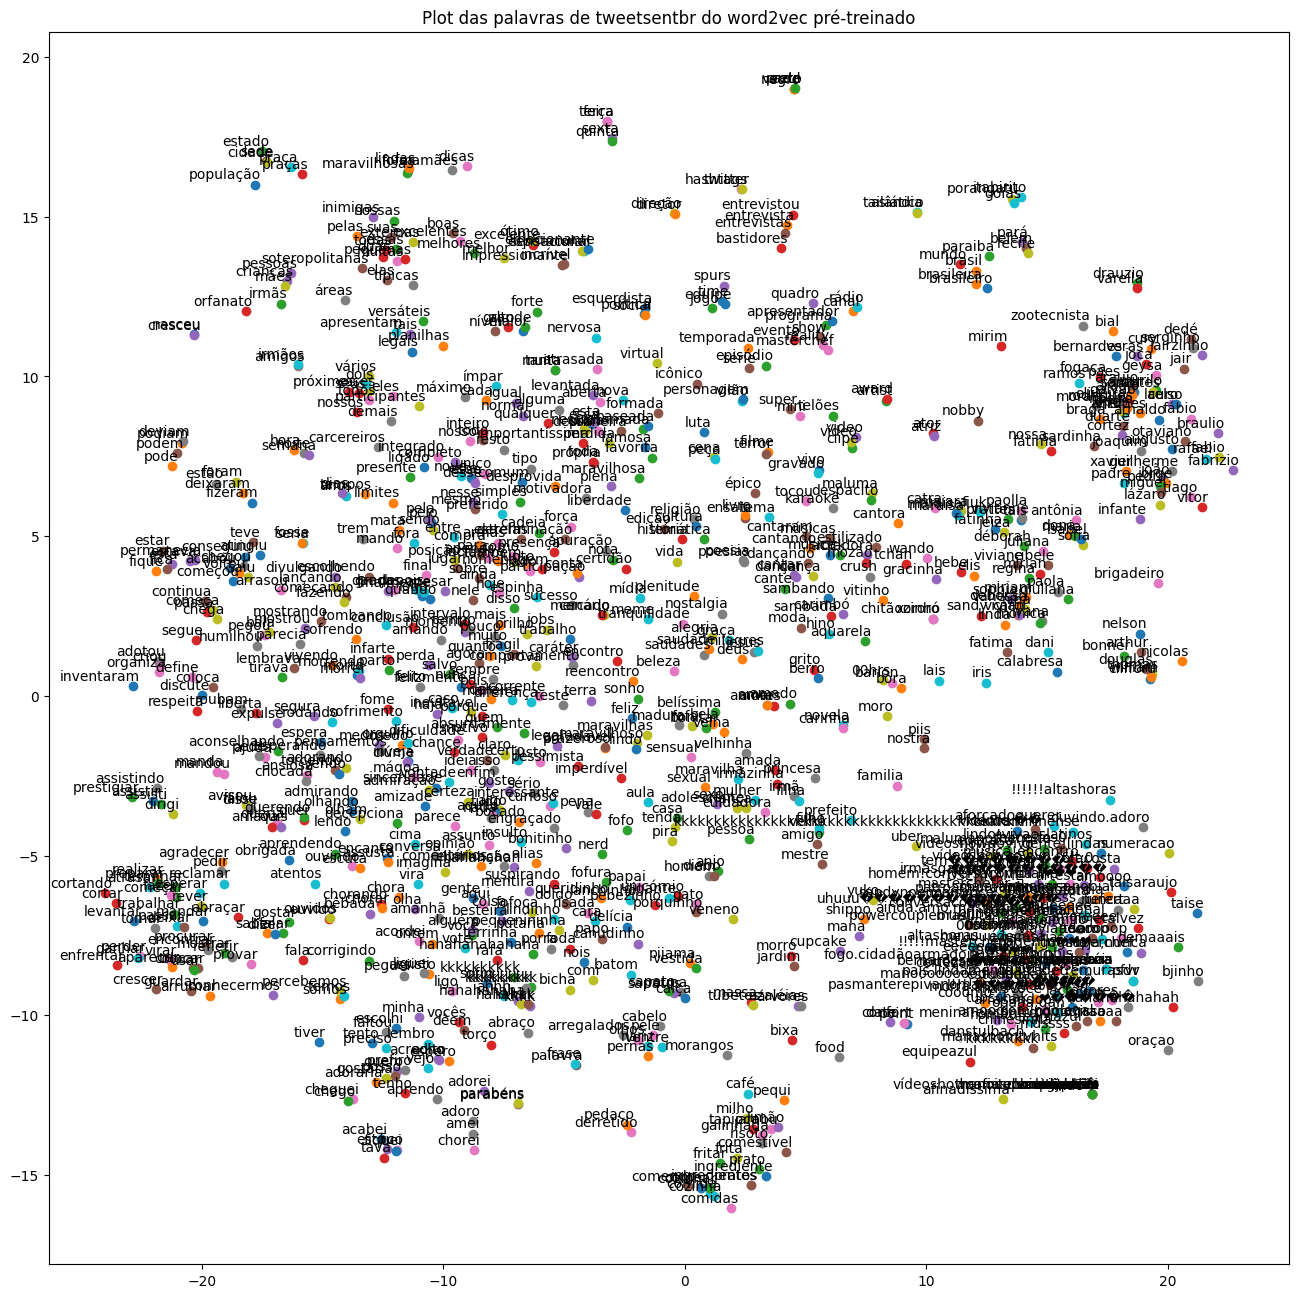

In [54]:
tsne_plot(palavras[:1000], wordvec_df[:1000], 'Plot das palavras de tweetsentbr do word2vec pré-treinado')

c:\Users\oknotok\Documents\computacao\tomorrow\modelos_de_linguagem_neurais\lain\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1000, 2)


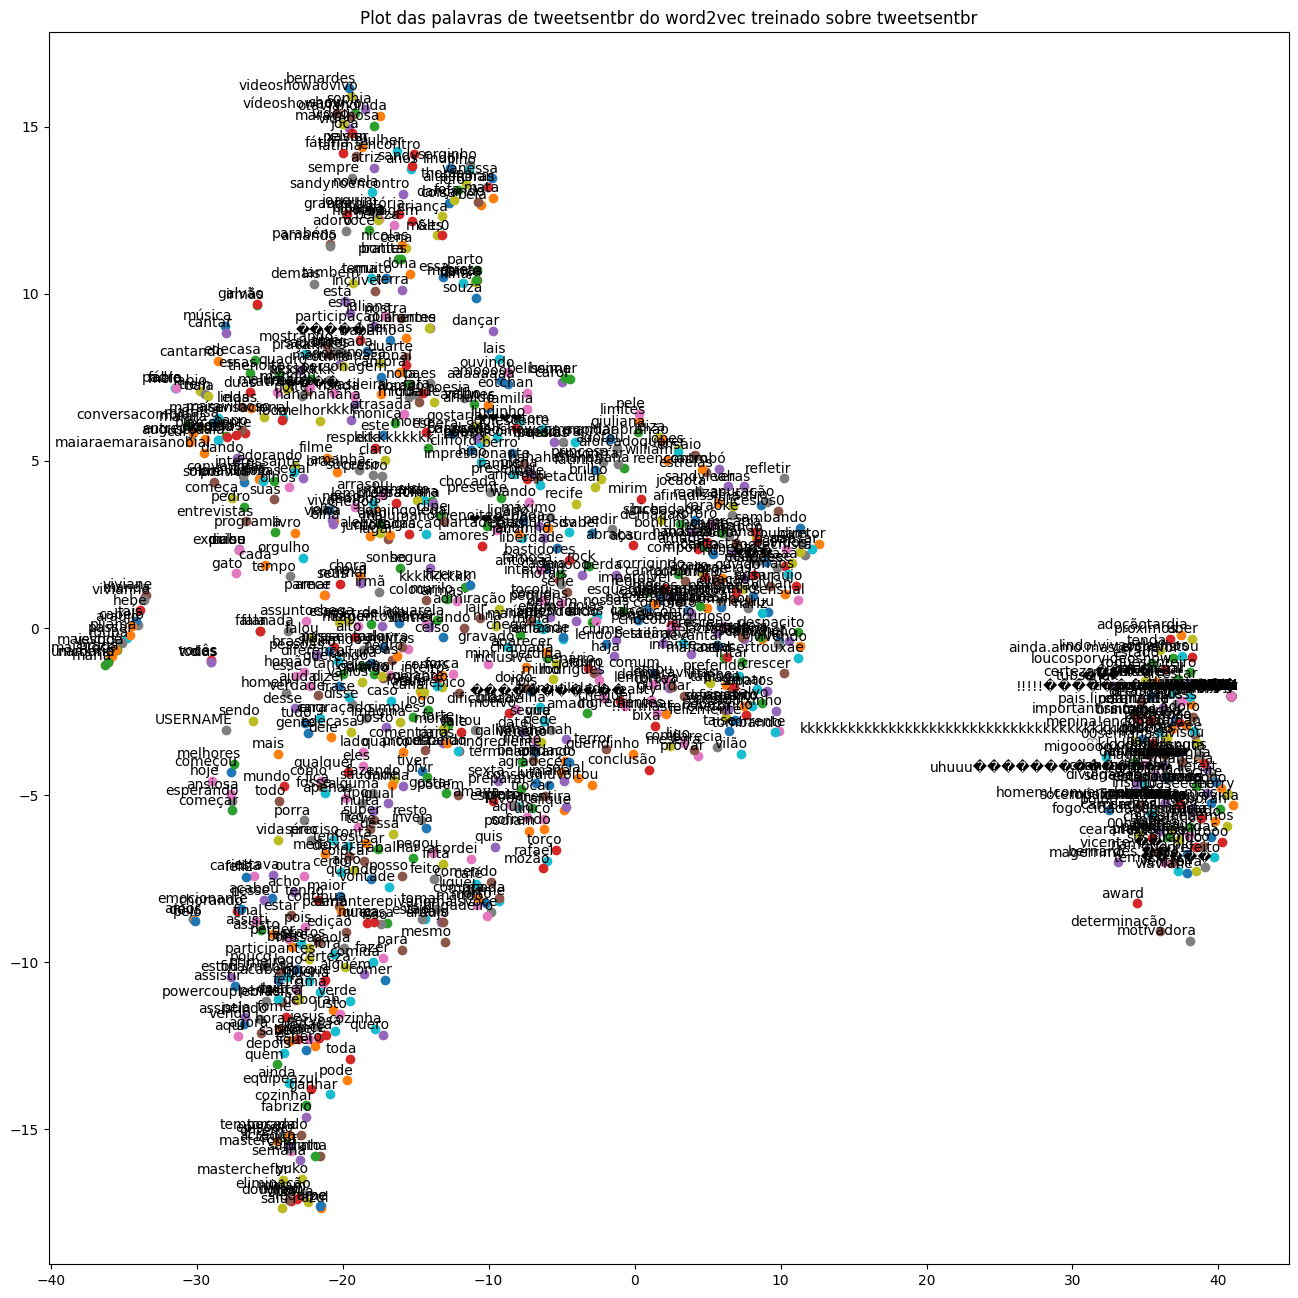

In [55]:
tsne_plot(palavras[:1000], wordvec_df_trained[:1000], 'Plot das palavras de tweetsentbr do word2vec treinado sobre tweetsentbr')